In [1]:
import torch
from torch.utils.data import DataLoader

from levee_hunter.plots import plot_training_validation_loss
from levee_hunter.segmentation_dataset import SegmentationDataset
from levee_hunter.utils import count_parameters
from levee_hunter.plots import infer_and_visualize
from levee_hunter.train_test_split_dataset import train_test_split_dataset
from levee_hunter.modeling.train import train_model
import numpy as np
import segmentation_models_pytorch as smp

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(


In [2]:
# Load the datasets
train_test_dataset = torch.load(
    "../data/intermediate/1m_512/train_test.pth", weights_only=False
)
validation_dataset = torch.load(
    "../data/intermediate/1m_512/validation.pth", weights_only=False
)
bad_dataset = torch.load(
    "../data/intermediate/1m_512/bad.pth", weights_only=False
)

print(len(train_test_dataset))
print(len(validation_dataset))
print(len(bad_dataset))

869
203
182


In [3]:
train_test_dataset.transform, validation_dataset.transform, bad_dataset.transform

('train_transform', 'train_transform', 'normalize_only')

In [4]:
train_test_dataset.weights_return, validation_dataset.weights_return, bad_dataset.weights_return

(False, False, False)

In [5]:
train_test_dataset.weights[:20]

tensor([2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [6]:
train_test_dataset.file_ids[:4]

['9cec86b0d0', '9cec86b0d0', '9cec86b0d0', '9cec86b0d0']

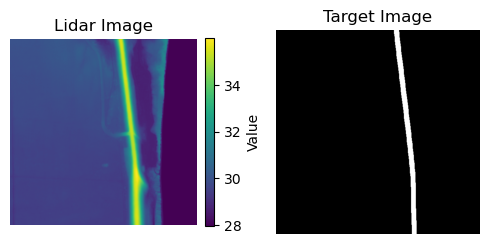

In [7]:
train_test_dataset.plot(0, figsize=(5,5))

In [8]:
training_dataset, test_dataset = train_test_split_dataset(train_test_dataset, test_size=0.115)

len(training_dataset), len(test_dataset)

(769, 100)

In [9]:
training_dataset.weights.shape

torch.Size([769])

In [10]:
training_dataset.weights_return = True

In [11]:
batch_size = 64

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

train_loader.dataset.images[0].shape, len(train_loader.dataset.images)

((1, 512, 512), 769)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Unet

In [30]:
model = smp.Unet(
    encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
model, train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=nn.BCEWithLogitsLoss(reduction="none"),
    epochs=50,
    save_model='best',
    save_model_path="../models/w5_models/Unet-1m_512.pth",
)

beginning training on device: cuda
Epoch: 1/50 Train Loss: 0.554751 Val Loss: 0.825026
Model successfully saved to: ../models/w5_models/Unet-1m_512.pth
Epoch: 2/50 Train Loss: 0.382406 Val Loss: 0.523545
Model successfully saved to: ../models/w5_models/Unet-1m_512.pth
Epoch: 3/50 Train Loss: 0.285750 Val Loss: 0.309892
Model successfully saved to: ../models/w5_models/Unet-1m_512.pth
Epoch: 4/50 Train Loss: 0.284770 Val Loss: 0.282193
Model successfully saved to: ../models/w5_models/Unet-1m_512.pth
Epoch: 5/50 Train Loss: 0.268390 Val Loss: 0.286450
Epoch: 6/50 Train Loss: 0.231762 Val Loss: 0.230886
Model successfully saved to: ../models/w5_models/Unet-1m_512.pth
Epoch: 7/50 Train Loss: 0.246310 Val Loss: 0.250307
Epoch: 8/50 Train Loss: 0.215785 Val Loss: 0.227660
Model successfully saved to: ../models/w5_models/Unet-1m_512.pth
Epoch: 9/50 Train Loss: 0.199413 Val Loss: 0.220151
Model successfully saved to: ../models/w5_models/Unet-1m_512.pth
Epoch: 10/50 Train Loss: 0.199783 Val Loss

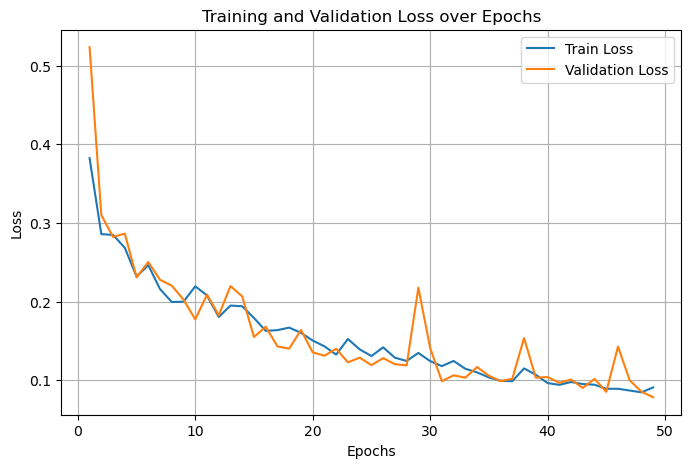

In [15]:
plot_training_validation_loss(train_loss[1:], val_loss[1:])

In [31]:
model.load_state_dict(torch.load("../models/w5_models/Unet-1m_512.pth"))
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [17]:
test_dataset.transform = 'normalize_only'

0


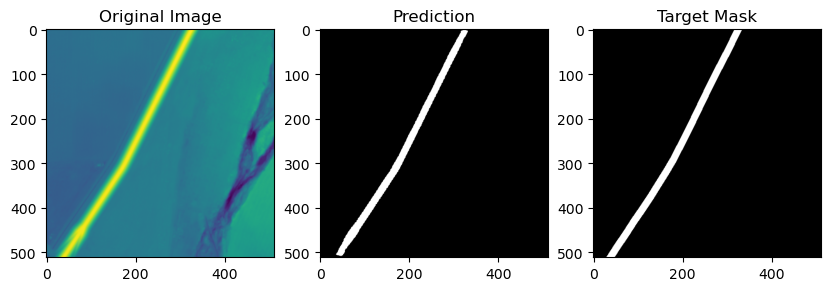

1


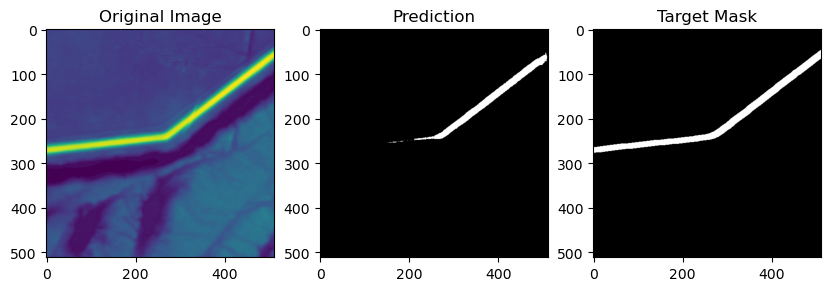

2


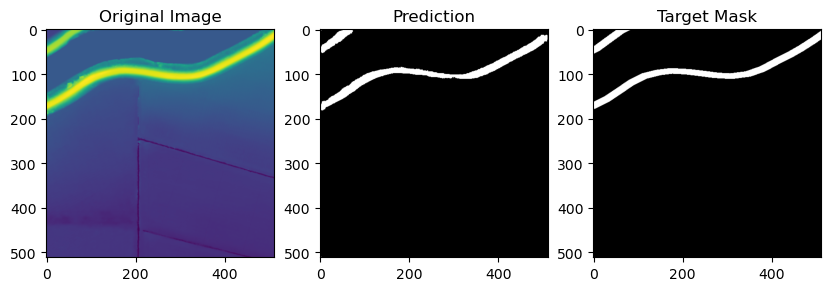

3


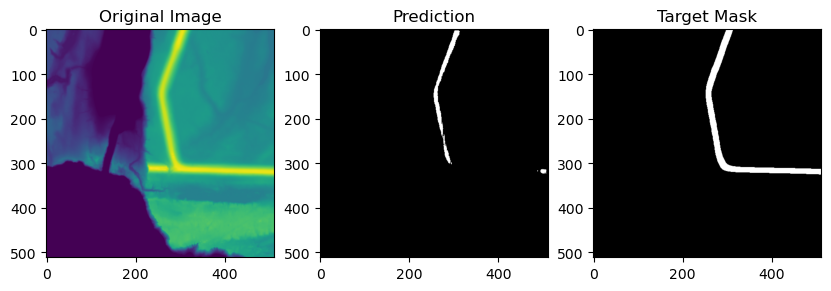

4


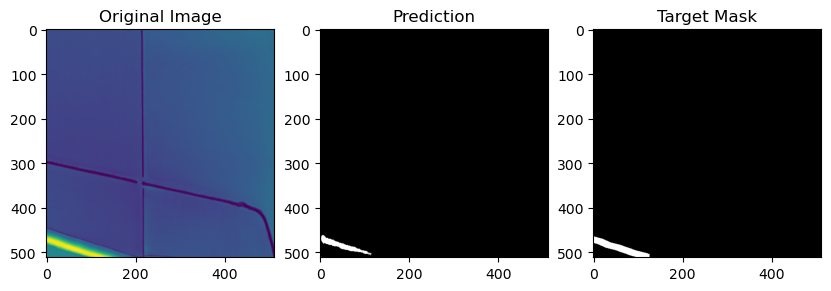

In [33]:
for ix in range(5):
    sample_image, sample_mask = test_dataset[ix]
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)

# Segformer

In [22]:
model = smp.Segformer(
    encoder_name="mit_b1", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

beginning training on device: cuda
Epoch: 1/50 Train Loss: 0.480966 Val Loss: 0.127621
Model successfully saved to: ../models/w5_models/Segformer-1m_512.pth
Epoch: 2/50 Train Loss: 0.278661 Val Loss: 0.115523
Model successfully saved to: ../models/w5_models/Segformer-1m_512.pth
Epoch: 3/50 Train Loss: 0.243031 Val Loss: 0.124329
Epoch: 4/50 Train Loss: 0.219935 Val Loss: 0.125360
Epoch: 5/50 Train Loss: 0.202298 Val Loss: 0.115385
Model successfully saved to: ../models/w5_models/Segformer-1m_512.pth
Epoch: 6/50 Train Loss: 0.183492 Val Loss: 0.101688
Model successfully saved to: ../models/w5_models/Segformer-1m_512.pth
Epoch: 7/50 Train Loss: 0.174515 Val Loss: 0.088283
Model successfully saved to: ../models/w5_models/Segformer-1m_512.pth
Epoch: 8/50 Train Loss: 0.147983 Val Loss: 0.074128
Model successfully saved to: ../models/w5_models/Segformer-1m_512.pth
Epoch: 9/50 Train Loss: 0.142402 Val Loss: 0.064581
Model successfully saved to: ../models/w5_models/Segformer-1m_512.pth
Epoch: 

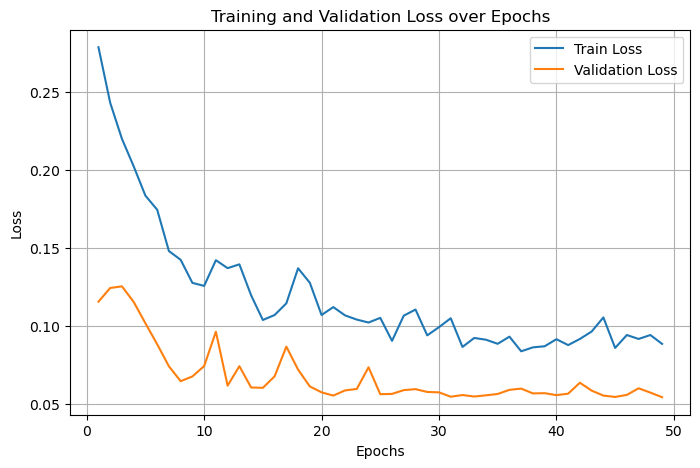

In [14]:
model, train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=nn.BCEWithLogitsLoss(reduction="none"),
    epochs=50,
    save_model='best',
    save_model_path="../models/w5_models/Segformer-1m_512.pth",
)

plot_training_validation_loss(train_loss[1:], val_loss[1:])



In [23]:
model.load_state_dict(torch.load("../models/w5_models/Segformer-1m_512.pth"))
model.eval()

Segformer(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_featur

In [35]:
validation_dataset.transform = 'normalize_only'

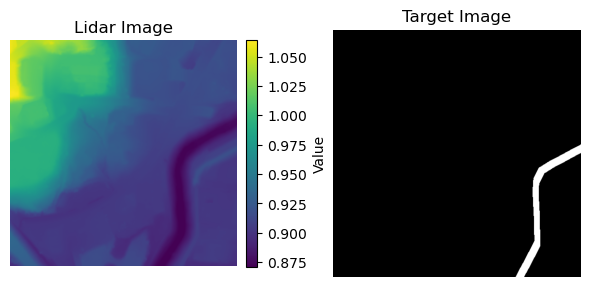

In [36]:
validation_dataset.plot(0, transform=True)

In [37]:
validation_dataset.images.shape

(203, 1, 512, 512)

In [38]:
validation_dataset.images[0]

array([[[270.04935, 270.086  , 270.11426, ..., 233.16202, 233.07054,
         232.95929],
        [270.07446, 270.11197, 270.1376 , ..., 233.17216, 233.10403,
         233.01506],
        [270.0852 , 270.1189 , 270.16144, ..., 233.16306, 233.09967,
         233.0358 ],
        ...,
        [228.45767, 228.4786 , 228.49002, ..., 228.27296, 228.26614,
         228.25842],
        [228.41194, 228.44437, 228.46754, ..., 228.27223, 228.26506,
         228.25446],
        [228.36702, 228.39574, 228.4263 , ..., 228.27449, 228.27446,
         228.26544]]], dtype=float32)

In [41]:
sample_image, sample_mask = validation_dataset[1]
sample_image

tensor([[[0.9162, 0.9160, 0.9159,  ..., 0.9615, 0.9614, 0.9612],
         [0.9161, 0.9160, 0.9159,  ..., 0.9622, 0.9620, 0.9618],
         [0.9162, 0.9160, 0.9159,  ..., 0.9629, 0.9627, 0.9625],
         ...,
         [0.8949, 0.8949, 0.8949,  ..., 1.0090, 1.0091, 1.0093],
         [0.8949, 0.8949, 0.8950,  ..., 1.0087, 1.0089, 1.0090],
         [0.8949, 0.8949, 0.8950,  ..., 1.0087, 1.0087, 1.0088]]])

In [42]:
sample_image, sample_mask = test_dataset[1]
sample_image

tensor([[[0.1021, 0.1021, 0.1021,  ..., 0.1013, 0.1014, 0.1015],
         [0.1020, 0.1020, 0.1020,  ..., 0.1013, 0.1013, 0.1013],
         [0.1020, 0.1020, 0.1019,  ..., 0.1013, 0.1012, 0.1012],
         ...,
         [0.1033, 0.1033, 0.1033,  ..., 0.1016, 0.1016, 0.1016],
         [0.1033, 0.1033, 0.1032,  ..., 0.1015, 0.1015, 0.1014],
         [0.1032, 0.1032, 0.1032,  ..., 0.1014, 0.1014, 0.1013]]])

In [44]:
np.mean(np.array(sample_image))

0.10282428

In [43]:
test_dataset.transform

Compose([
  Normalize(p=1.0, mean=0.0, std=1.0, max_pixel_value=255.0, normalization='standard'),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

0


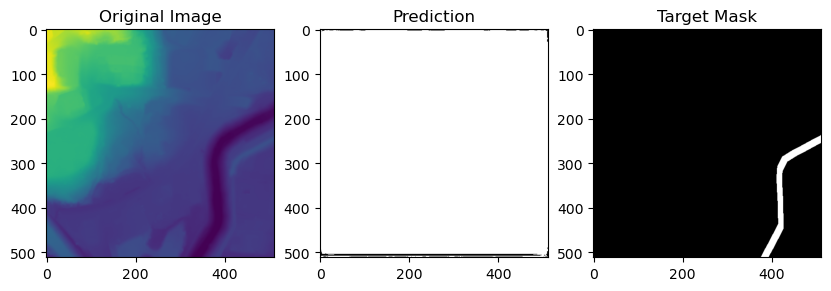

1


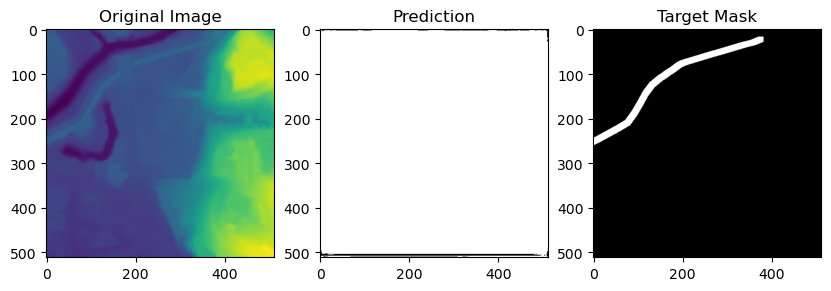

2


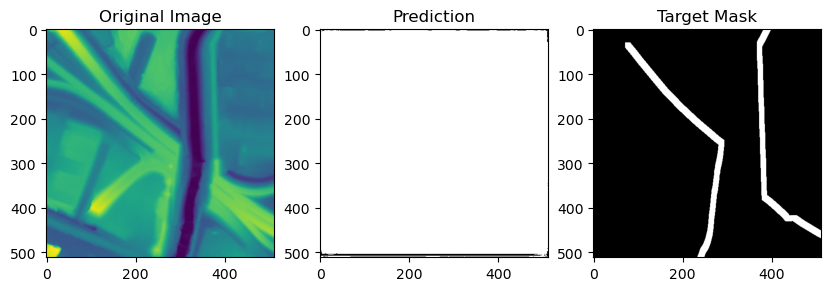

3


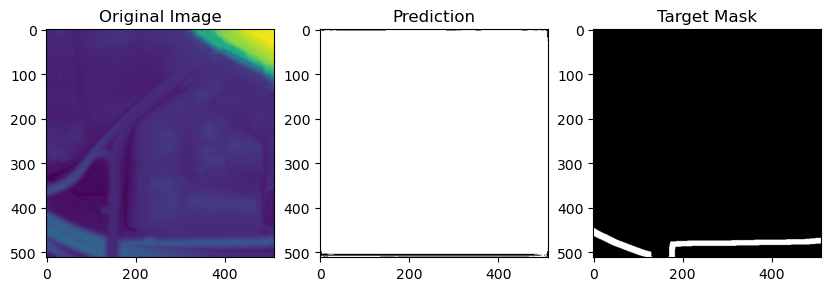

4


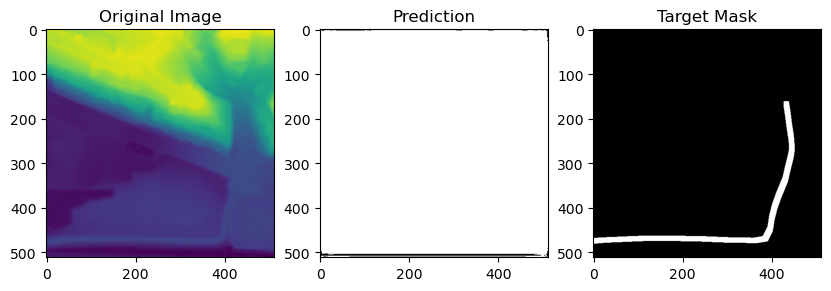

5


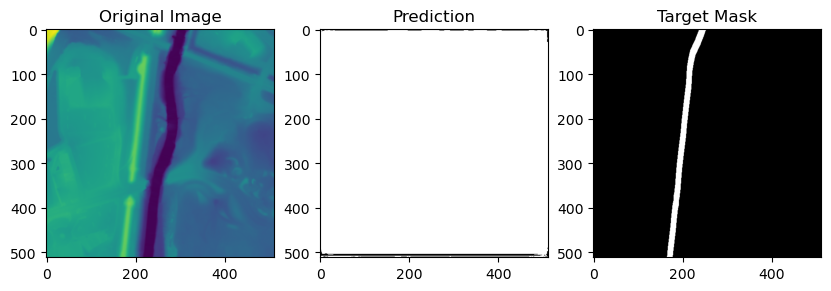

6


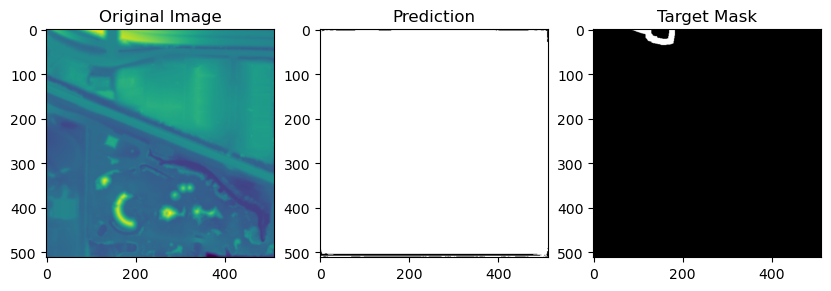

7


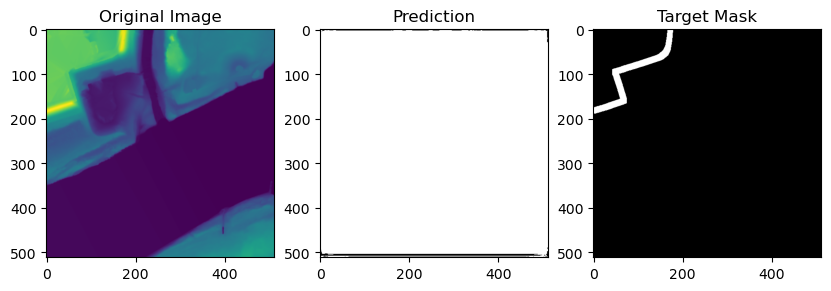

8


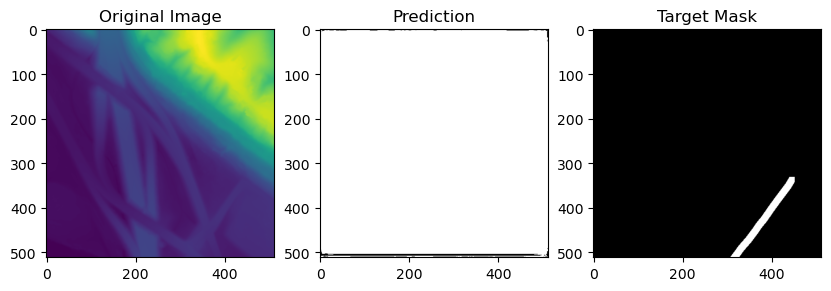

9


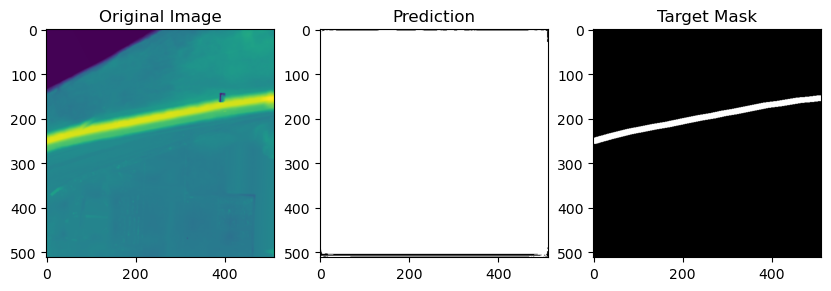

10


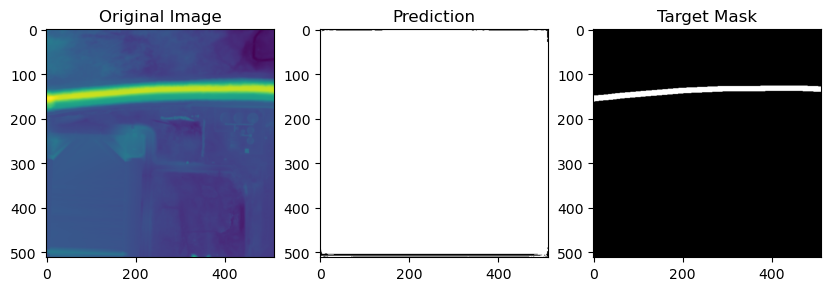

11


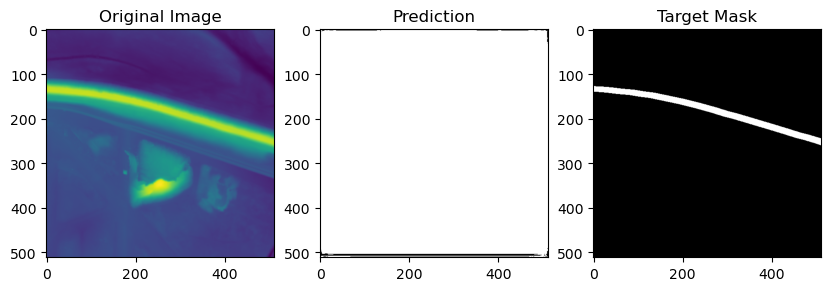

12


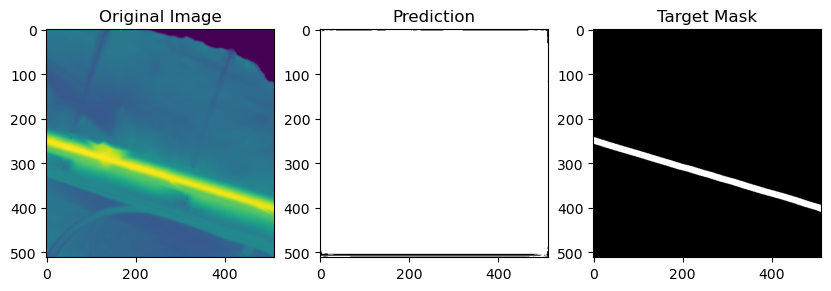

13


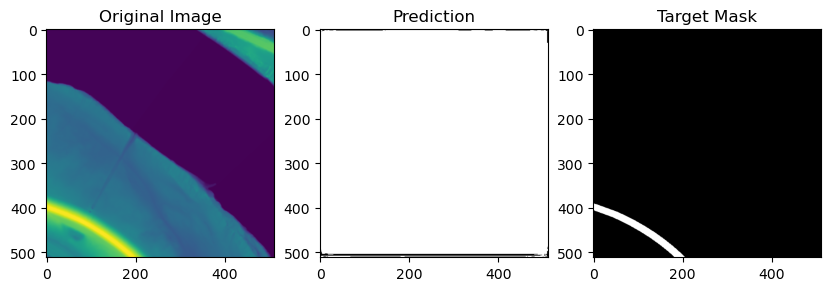

14


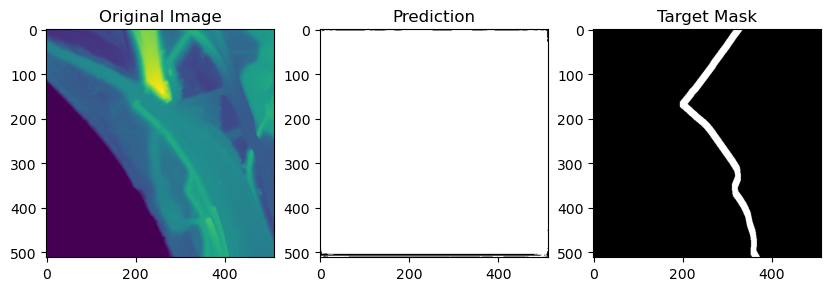

15


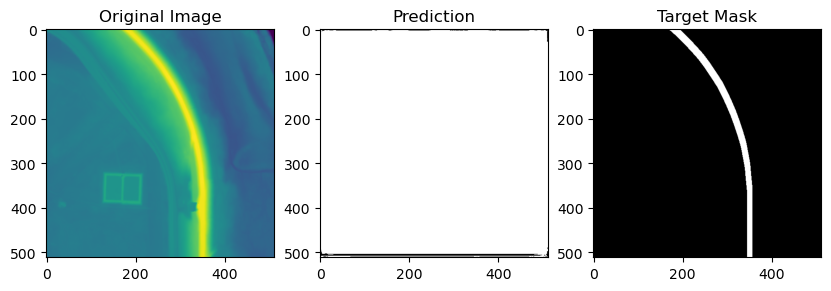

16


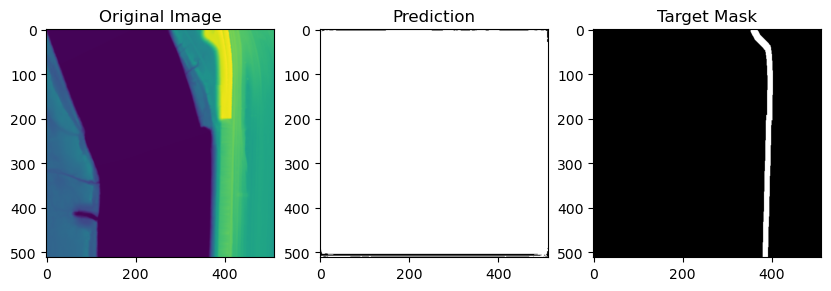

17


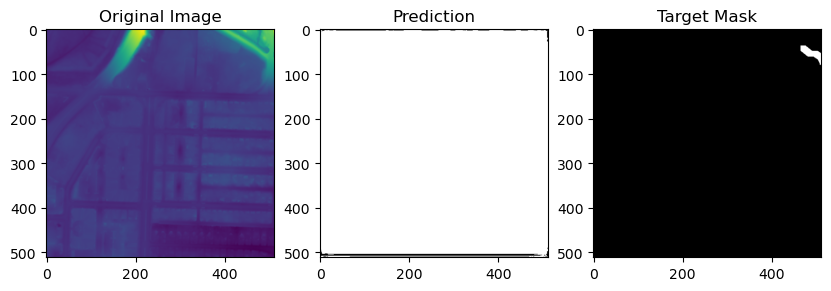

18


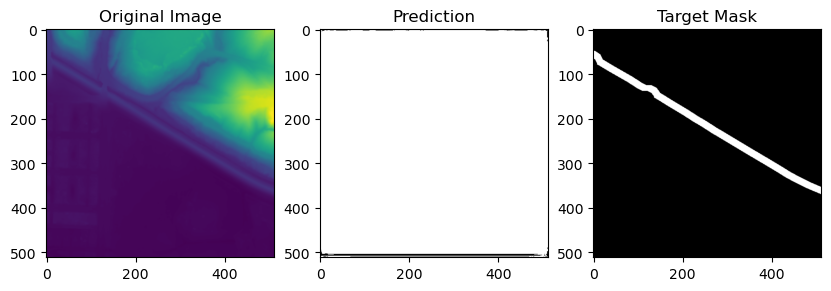

19


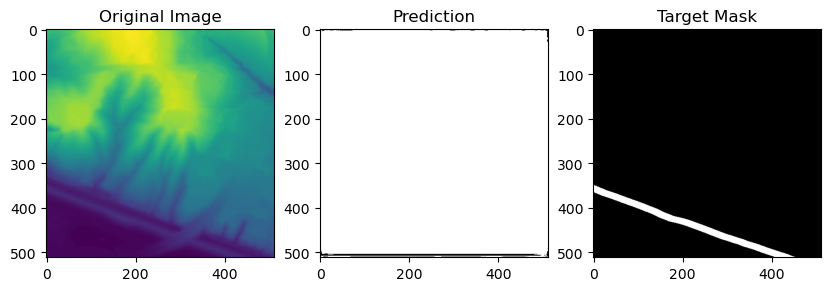

20


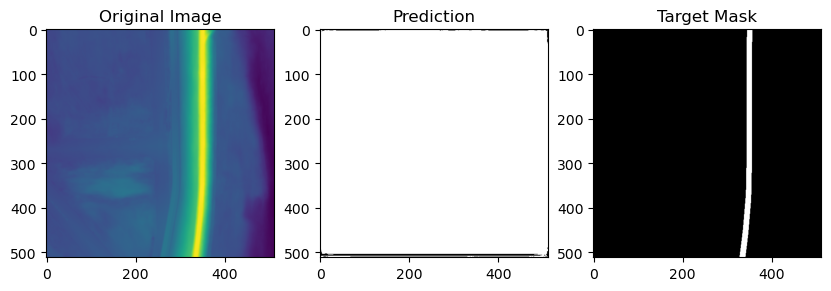

21


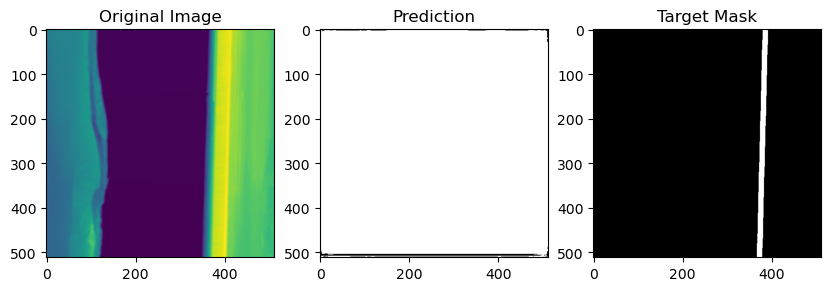

22


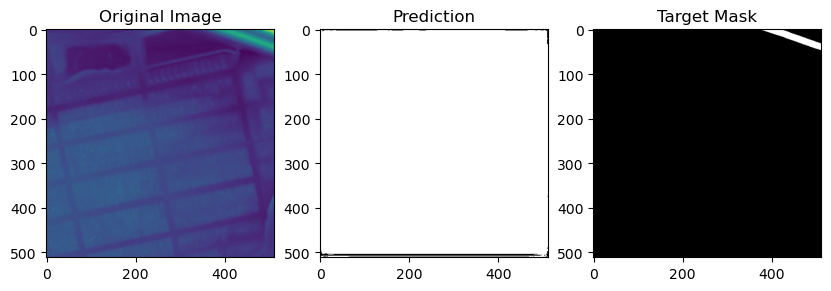

23


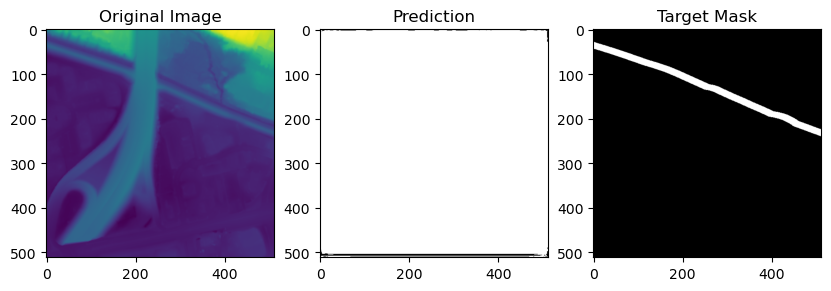

24


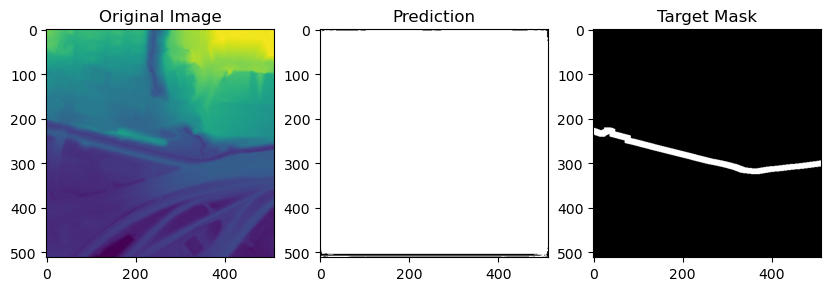

In [40]:
for ix in range(25):
    sample_image, sample_mask = validation_dataset[ix]
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)

In [22]:
validation_dataset.transform

'train_transform'

0


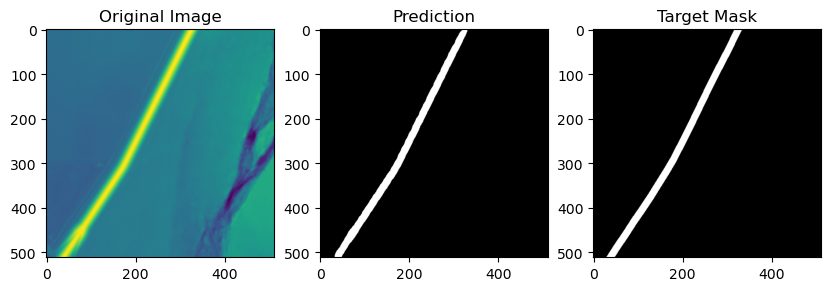

1


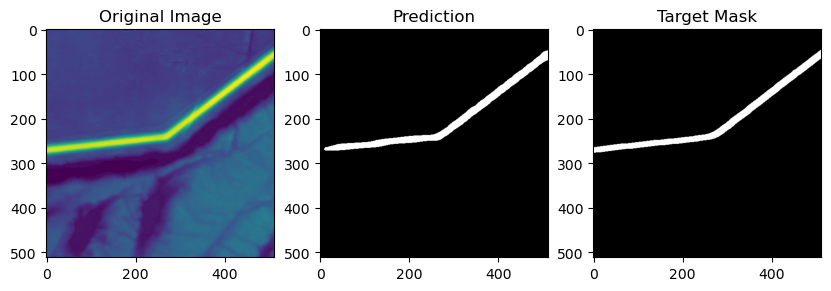

2


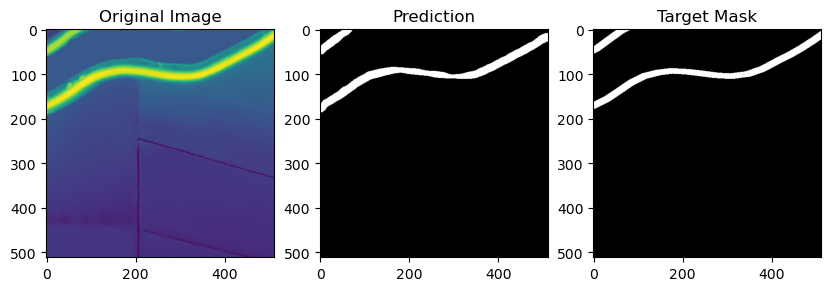

3


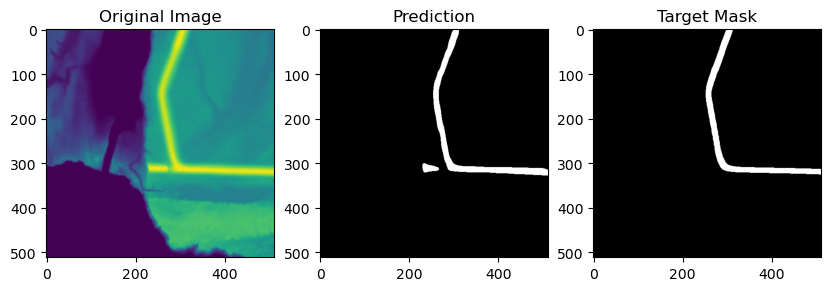

4


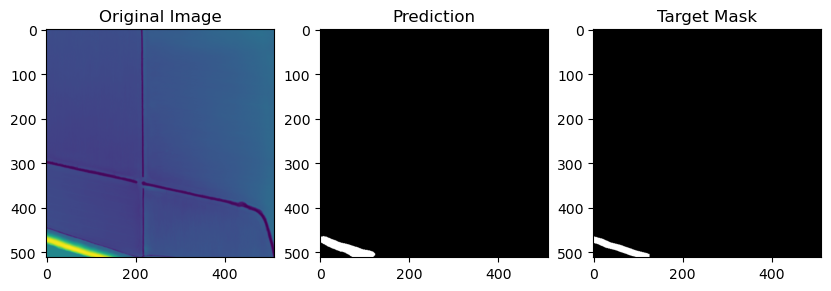

5


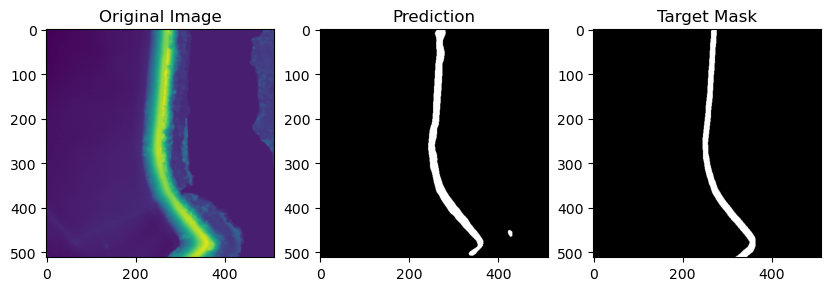

6


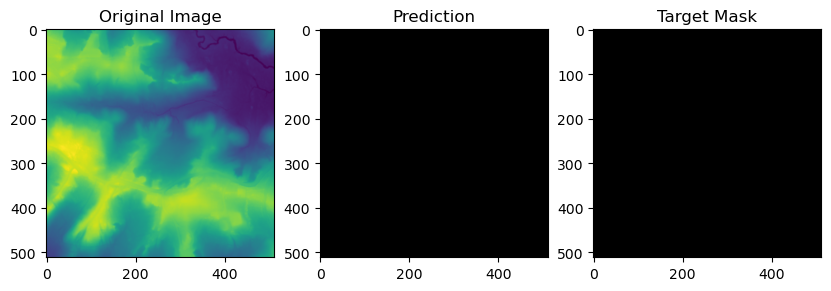

7


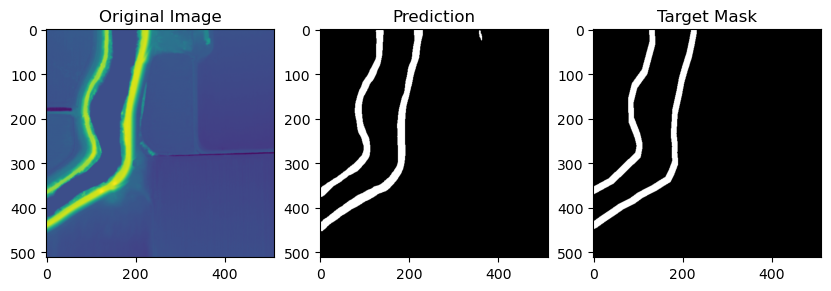

8


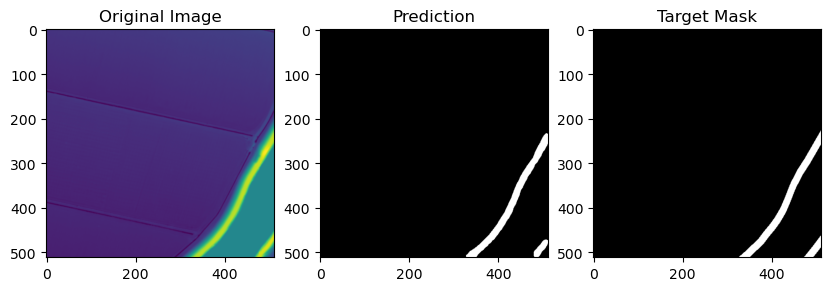

9


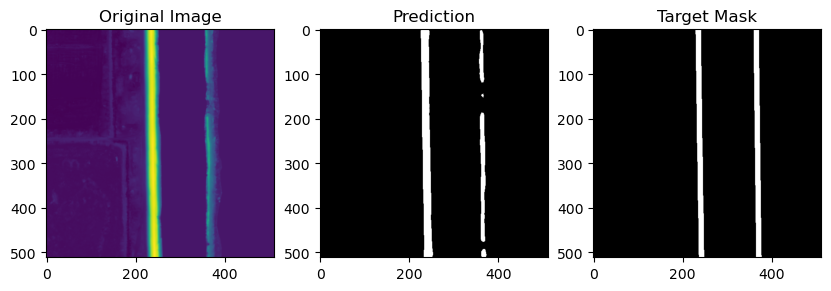

10


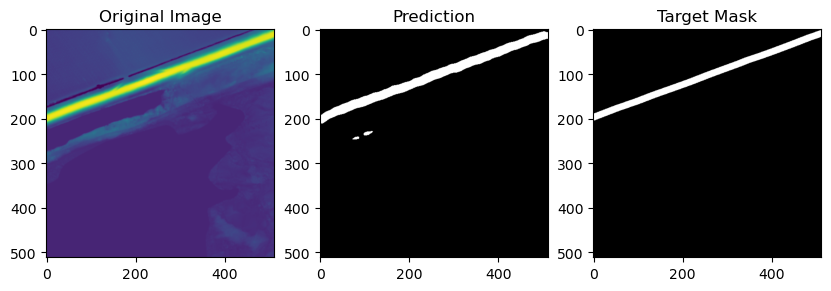

11


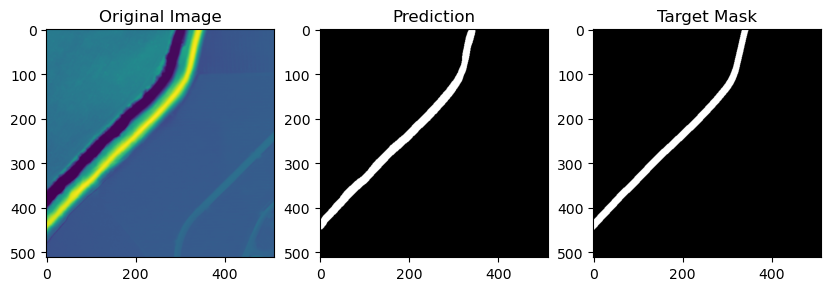

12


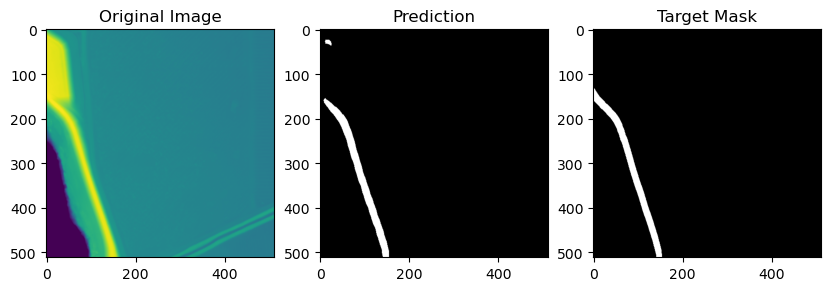

13


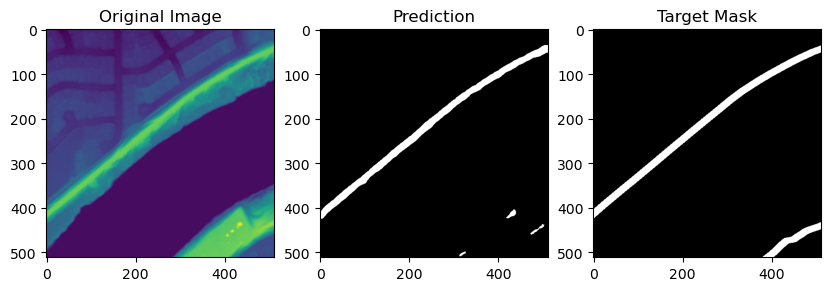

14


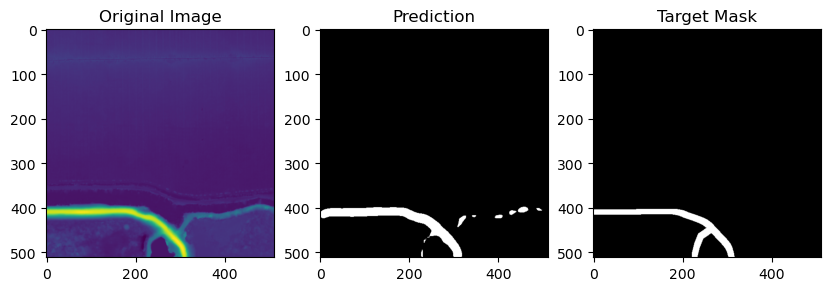

15


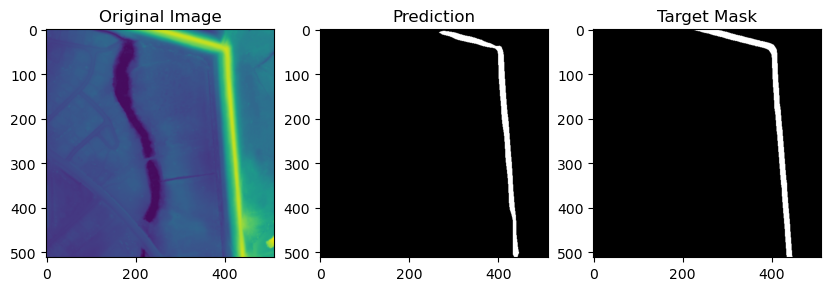

16


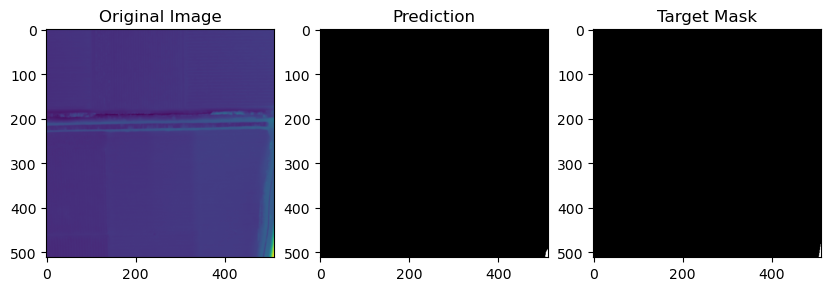

17


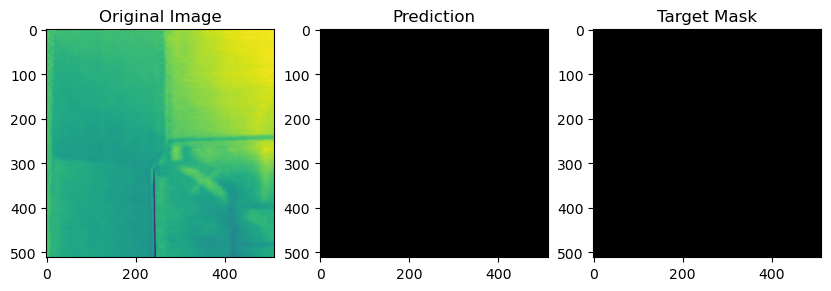

18


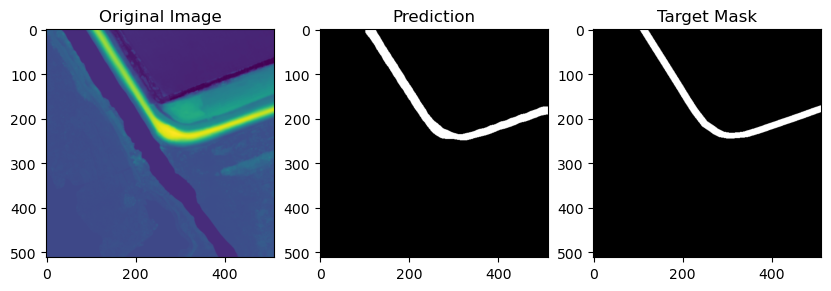

19


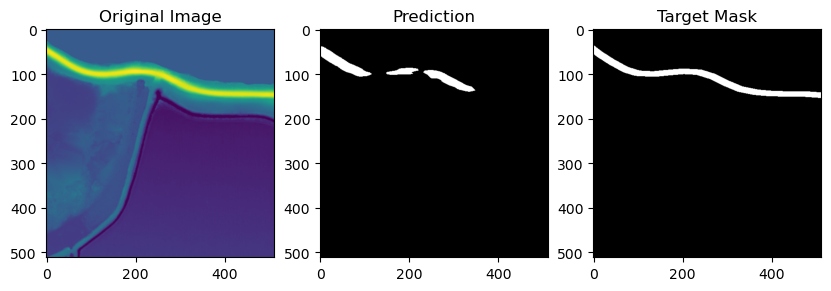

20


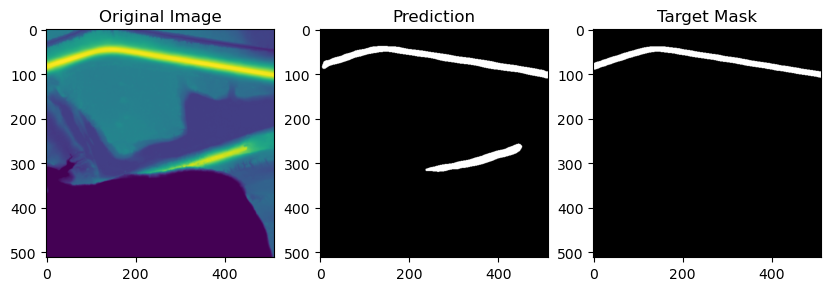

21


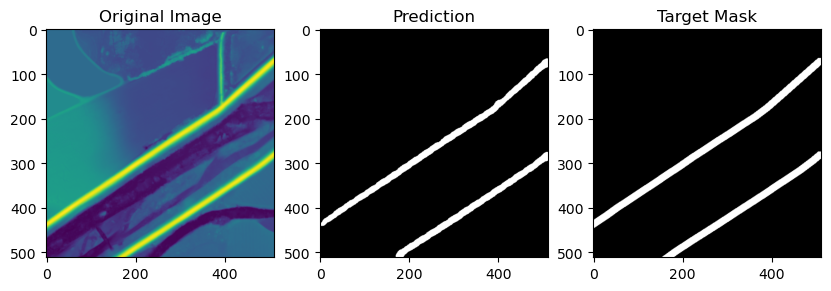

22


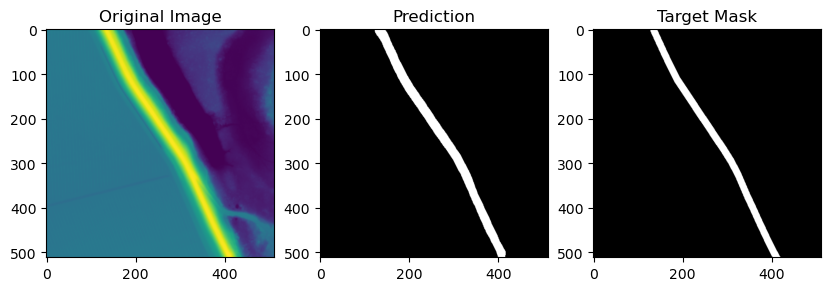

23


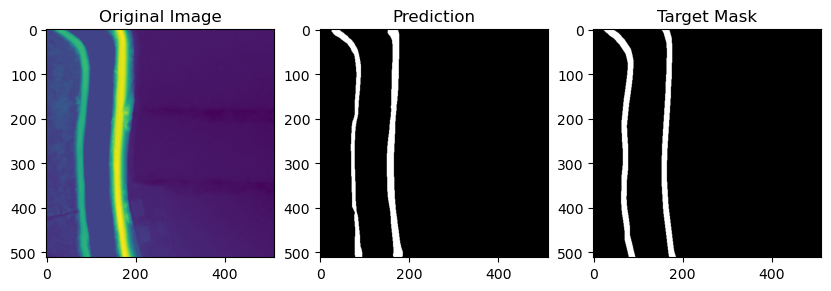

24


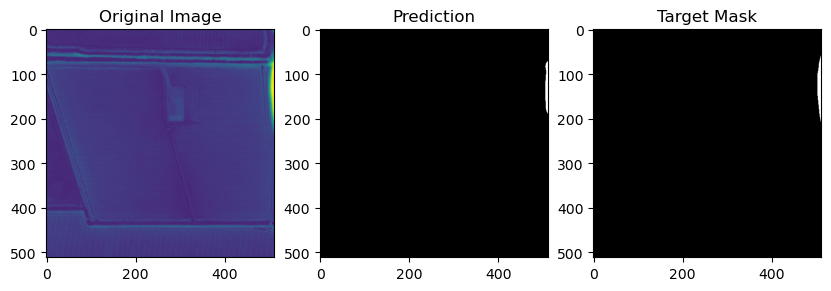

In [23]:
for ix in range(25):
    sample_image, sample_mask = test_dataset[ix]
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)

# DDD

In [17]:
from monai.losses import TverskyLoss

tversky_loss = TverskyLoss(alpha=0.3, beta=0.7, reduction="none")

In [18]:
model = smp.Segformer(
    encoder_name="mit_b1", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
model, train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=tversky_loss,
    epochs=50,
    save_model='best',
    save_model_path="../models/w5_models/Segformer-1m_512_T.pth",
)

plot_training_validation_loss(train_loss[1:], val_loss[1:])

beginning training on device: cuda


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
model.load_state_dict(torch.load("../models/w5_models/Segformer-1m_512_T.pth"))
model.eval()

for ix in range(5):
    sample_image, sample_mask = test_dataset[ix]
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)